In [195]:
import pandas as pd
import os
import shapely.geometry as sg
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint
from shapely.ops import unary_union
data_directory = os.path.join('..', 'data', 'ptv', '20240224')

In [1]:

ROUTE_TYPES = {
    0 : 'Tram',
    1 : 'Metro',
    2 : 'Rail',
    3 : 'Bus',
    4 : 'Ferry',
    5 : 'Cable tram',
    6 : 'Gondola',
    7 : 'Funicular',
    11 : 'Trolleybus',
    12 : 'Monorail',
}
ROUTE_TYPES_LONG = {
    0 : 'Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.',
    1 : 'Subway, Metro. Any underground rail system within a metropolitan area.',
    2 : 'Rail. Used for intercity or long-distance travel.',
    3 : 'Bus. Used for short- and long-distance bus routes.',
    4 : 'Ferry. Used for short- and long-distance boat service.',
    5 : 'Cable tram. Used for street-level rail cars where the cable runs beneath the vehicle, e.g., cable car in San Francisco.',
    6 : 'Aerial lift, suspended cable car (e.g., gondola lift, aerial tramway). Cable transport where cabins, cars, gondolas or open chairs are suspended by means of one or more cables.',
    7 : 'Funicular. Any rail system designed for steep inclines.',
    11 : 'Trolleybus. Electric buses that draw power from overhead wires using poles.',
    12 : 'Monorail. Railway in which the track consists of a single rail or a beam.',
}

BRANCH_IDS_ALL = ['1', '2', '3', '4', '5', '6', '7', '8', '10', '11']
BRANCH_IDS = ['1', '2', '3', '4', '5', '6', '10', '11']
TABLE_NAMES = ['stop_times', 'stops', 'trips', 'routes', 'calendar', 'calendar_dates', 'agency', 'shapes']
# GTFS File Fields
# agency.txt 
# agency_id, agency_name, agency_url, agency_timezone, agency_lang
# calendar.txt 
# service_id, monday, tuesday, wednesday, thursday, friday, saturday, sunday, start_date, end_date
# calendar_dates.txt 
# service_id ,date, exception_type
# routes.txt 
# route_id, agency_id, route_short_name, route_long_name,
# route_type, route_color,route_text_color
# trips.txt 
# route_id, service_id, trip_id, shape_id, trip_headsign, direction_id
# stops.txt 
# stop_id, stop_name, stop_lat, stop_lon
# stop_times.txt 
# trip_id, arrival_time, departure_time, stop_id, stop_sequence, stop_headsign, pickup_type, drop_off_type, shape_dist_traveled
# shapes.txt 
# shape_id, shape_pt_lat, shape_pt_lon, shape_pt_sequence, shape_dist_traveled 
def get_df(branch_id, table_name):
    files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.split('-')[1] == str(branch_id) and f.split('-')[2] == table_name]
    if len(files) == 0:
        return None
    return pd.concat([pd.read_csv(f, keep_default_na=False, na_values=['']) for f in files])

DF = {branch_id: {table_name: get_df(branch_id, table_name) for table_name in TABLE_NAMES} for branch_id in BRANCH_IDS_ALL}
# 15s - 30s


In [2]:

# Assert all shape_id contains route_id
for bid in BRANCH_IDS:
    assert DF[bid]['trips'].dropna(subset=['route_id', 'shape_id']).apply(lambda x: x['route_id'] in x['shape_id'], axis=1).all(), bid

# Assert all shape start with distance = 0
for bid in BRANCH_IDS:
    assert DF[bid]['shapes'][DF[bid]['shapes']['shape_pt_sequence'] == 1]['shape_dist_traveled'].unique() == [0], bid


In [3]:
# Add stop names to stop_times, to make it easier to read
for bid in BRANCH_IDS:
    DF[bid]['stop_times'] = pd.merge(DF[bid]['stop_times'], DF[bid]['stops'], on='stop_id')
    DF[bid]['stop_times'].sort_values(by=['trip_id', 'stop_sequence'], inplace=True)
# 15s - 30s

In [6]:

# Get list of stops for each trip
for bid in BRANCH_IDS:
    DF[bid]['trip_stops'] = DF[bid]['stop_times'].sort_values(by=['trip_id', 'stop_sequence']).groupby('trip_id')['stop_id'].apply(np.array).reset_index()
    DF[bid]['trip_stops']['stops_count'] = DF[bid]['trip_stops']['stop_id'].apply(len)
# 10s - 30s. Faster when using np.array instead of list or .apply(lambda x: x.to_numpy())

In [7]:
# Equivalently, get list of stop sequence for each trip
for bid in BRANCH_IDS:
    df_trip_stopsorder = DF[bid]['stop_times'].groupby('trip_id')['stop_sequence'].apply(np.array)
    DF[bid]['trip_stops'] = pd.merge(df_trip_stopsorder, DF[bid]['trip_stops'], on='trip_id')
# 5s - 10s

In [8]:
# Get full information about trips, including stop sequence and route, shape ids
for bid in BRANCH_IDS:
    DF[bid]['trips_full'] = pd.merge(DF[bid]['trips'], DF[bid]['trip_stops'], on='trip_id')
    DF[bid]['trips_full']['stop_pattern'] = DF[bid]['trips_full']['stop_id'].apply(lambda x: '-'.join([str(i) for i in x]))
# 3s - 5s

In [9]:
# Concatenate all trips_full
DFTRIPSFULL : pd.DataFrame = pd.concat([DF[bid]['trips_full'] for bid in BRANCH_IDS])

# Confirm that each shape_id has only one stop_pattern (stop sequence)
assert DFTRIPSFULL.groupby('shape_id')['stop_pattern'].nunique().unique() == [1]


In [10]:
for bid in BRANCH_IDS:
    DF[bid]['shape_stops'] = DF[bid]['trips_full'].groupby('shape_id')['stop_pattern'].unique().apply(lambda x: x[0]).reset_index()

DFSHAPESTOPS = pd.concat([DF[bid]['shape_stops'] for bid in BRANCH_IDS])

In [12]:

for bid in BRANCH_IDS:
    DF[bid]['shapes'].sort_values(by=['shape_id', 'shape_pt_sequence'], inplace=True)
    DF[bid]['shapes']['points'] = list(zip(DF[bid]['shapes']['shape_pt_lon'], DF[bid]['shapes']['shape_pt_lat']))
    DF[bid]['lines'] = DF[bid]['shapes'].groupby('shape_id').apply(lambda x: x['points'].to_numpy()).rename('line').reset_index()
# 15s - 30s
    
for bid in BRANCH_IDS:
    DF[bid]['lines']['direction'] = DF[bid]['lines']['shape_id'].transform(lambda x: ''.join(x.split('.')[-1]))
    DF[bid]['lines']['route_id'] = DF[bid]['lines']['shape_id'].transform(lambda x: ''.join(x.split('.')[0]))
    DF[bid]['lines']['route_name'] = DF[bid]['lines']['route_id'].transform(lambda x: ''.join(x.split('-')[1:-2]))
    DF[bid]['lines']['branch'] = DF[bid]['lines']['shape_id'].transform(lambda x: x.split('-')[0])
    DF[bid]['lines']['class'] = bid

# Total 2m    
    
DFLINES : pd.DataFrame = pd.concat([DF[bid]['lines'] for bid in BRANCH_IDS])

DFLINES = pd.merge(DFLINES, DFSHAPESTOPS, on='shape_id')

DFLINES['stops'] = DFLINES['stop_pattern'].apply(lambda x: x.split('-'))
DFLINES['points_count'] = DFLINES['line'].apply(len)
DFLINES['stops_count'] = DFLINES['stops'].apply(len)

DFLINES = DFLINES[['route_name', 'direction', 'branch', 'class', 'route_id', 'shape_id', 'stop_pattern', 'stops', 'stops_count', 'line', 'points_count']]

DFLINES.sort_values(
    by=['class', 'route_name', 'branch', 'direction', 'stops_count', 'points_count', 'stop_pattern'], 
    ascending=[True, True, True, True, False, False, True],
    inplace=True, 
)

DFLINES.reset_index(drop=True, inplace=True)

# Total: 1m 30s - 2m

In [13]:
DFSTOPPATTERNS = DFLINES.drop_duplicates(subset=['route_name', 'class', 'direction', 'stop_pattern'])[['route_name', 'class', 'direction', 'stop_pattern', 'stops', 'stops_count']]

DFROUTESTOPS = DFSTOPPATTERNS[['route_name', 'class', 'direction', 'stops']].explode('stops').reset_index(drop=True)
DFROUTESTOPS = DFROUTESTOPS.groupby(['route_name', 'class', 'direction'])['stops'].unique().reset_index()
DFROUTESTOPS['stops_count'] = DFROUTESTOPS['stops'].apply(len)
DFROUTESTOPS.rename(columns={'stops': 'stopset', 'stops_count' : 'stopsetsize'}, inplace=True)

DFSTOPPATTERNS.sort_values(by=['class', 'route_name', 'direction', 'stops_count', 'stop_pattern'], ascending=[True, True, True, False, True], inplace=True)
DFSTOPPATTERNS.reset_index(drop=True, inplace=True)

def find_smallest_number_of_lists(lists):
    # Create a set to store all unique elements from all lists
    all_elements = set()
    for lst in lists:
        all_elements.update(lst)

    # Initialize an empty list to store the selected lists
    selected_lists = []

    # Iterate until all elements are covered
    while all_elements:
        # Find the list that covers the maximum number of uncovered elements
        max_covered = set()
        max_list = None
        for lst in lists:
            covered = set(lst).intersection(all_elements)
            if len(covered) > len(max_covered):
                max_covered = covered
                max_list = lst

        # Remove covered elements from the set of all elements
        all_elements.difference_update(max_covered)

        # Add the selected list to the result
        selected_lists.append(max_list)

    return selected_lists


DFROUTEPATTERNSMULTI = DFSTOPPATTERNS.groupby(['route_name', 'class', 'direction'])['stops'].apply(list).rename('stop_patterns').reset_index()
DFROUTEPATTERNSMULTI['stop_patterns'] = DFROUTEPATTERNSMULTI['stop_patterns'].apply(lambda x: sorted(x, key=lambda y: len(y), reverse=True))
DFROUTEPATTERNSMULTI['spcover'] = DFROUTEPATTERNSMULTI['stop_patterns'].apply(lambda x: find_smallest_number_of_lists(x))
DFROUTEPATTERNSMULTI['stop_patterns_len'] = DFROUTEPATTERNSMULTI['stop_patterns'].apply(len)
DFROUTEPATTERNSMULTI['spcover_len'] = DFROUTEPATTERNSMULTI['spcover'].apply(len)
DFROUTEPATTERNSMULTI['diff'] = DFROUTEPATTERNSMULTI['stop_patterns_len'] - DFROUTEPATTERNSMULTI['spcover_len']
DFROUTEPATTERNSMULTI['spcoverid'] = DFROUTEPATTERNSMULTI['spcover'].apply(lambda lst: ['-'.join(lst1) for lst1 in lst])
DFROUTEPATTERNSMULTI.sort_values(by=['spcover_len', 'diff'], ascending=[False, True], inplace=True)
DFROUTEPATTERNSMULTI.reset_index(drop=True, inplace=True)

DFROUTEPATTERNCOVER = DFROUTEPATTERNSMULTI.explode('spcoverid').reset_index(drop=True)[['route_name', 'class', 'direction', 'spcoverid']]
DFROUTEPATTERNCOVER.rename(columns={'spcoverid': 'stop_pattern'}, inplace=True)

DFSTOPPATTERNSMIN = pd.merge(DFSTOPPATTERNS, DFROUTEPATTERNCOVER, on=['route_name', 'class', 'direction', 'stop_pattern'], how='right')
DFSTOPPATTERNSMIN.sort_values(by=['class', 'route_name', 'direction', 'stops_count', 'stop_pattern'], ascending=[True, True, True, False, True], inplace=True)
DFSTOPPATTERNSMIN.reset_index(drop=True, inplace=True)
# DFSTOPPATTERNSMIN: Minimal selected stop patterns that cover all stops for each route


In [125]:
DFLINESMULTI = DFLINES.groupby(['route_name', 'class', 'direction'])['line'].apply(np.array).rename('lines').reset_index()
DFLINESMULTI['lines_cover'] = DFLINESMULTI['lines'].apply(lambda x: find_smallest_number_of_lists(x))
# 20s - 1m

In [126]:
DFLINESMULTI['lines_cover_count'] = DFLINESMULTI['lines_cover'].apply(len)
DFLINESMULTI['lines_full_count'] = DFLINESMULTI['lines'].apply(len)

In [127]:
DFLINESMULTI['geo_full'] = DFLINESMULTI['lines'].apply(lambda x: [LineString(i) for i in x])
DFLINESMULTI['union_full'] = DFLINESMULTI['geo_full'].apply(unary_union)
DFLINESMULTI['geom_full_count'] = DFLINESMULTI['union_full'].apply(lambda x: len(x.geoms) if x.geom_type == 'MultiLineString' else 1)
# 12m - 15m

In [128]:
DFLINESMULTI['geo_cover'] = DFLINESMULTI['lines_cover'].apply(lambda x: [LineString(i) for i in x])
# 2s - 5s
DFLINESMULTI['union_cover'] = DFLINESMULTI['geo_cover'].apply(unary_union)
# 1s - 2s
DFLINESMULTI['geom_cover_count'] = DFLINESMULTI['union_cover'].apply(lambda x: len(x.geoms) if x.geom_type == 'MultiLineString' else 1)

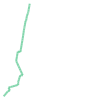

In [130]:
DFLINESMULTI.iloc[0]['union_full']

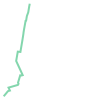

In [131]:
DFLINESMULTI.iloc[0]['union_cover']

In [134]:
DFLINESGEOFULL = DFLINESMULTI[['route_name', 'class', 'direction', 'union_full', 'geom_full_count']]

In [136]:
# Convert linestring to array of points
DFLINESGEOFULL['points_full'] = DFLINESGEOFULL['union_full'].apply(lambda x: np.array(x.geoms) if x.geom_type == 'MultiLineString' else np.array([x]))
# 5s - 10s
DFLINESGEOFULL = DFLINESGEOFULL.explode('points_full').reset_index(drop=True)
DFLINESGEOFULL['points_full'] = DFLINESGEOFULL['points_full'].apply(lambda x: np.array(x.coords))
# 5s - 10s
DFLINESGEOFULL['points_len'] = DFLINESGEOFULL['points_full'].apply(len)
DFLINESGEOFULL = DFLINESGEOFULL[['route_name', 'class', 'direction', 'points_full', 'points_len']]

DFLINESGEOFULL = DFLINESGEOFULL.groupby(['route_name', 'class', 'direction'])['points_full'].apply(np.array).reset_index()
DFLINESGEOFULL.rename(columns={'points_full': 'lines'}, inplace=True)
DFLINESGEOFULL['lines_count'] = DFLINESGEOFULL['lines'].apply(len)

C:\Users\An\AppData\Local\Temp\ipykernel_9320\1232868180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DFLINESGEOFULL['points_full'] = DFLINESGEOFULL['union_full'].apply(lambda x: np.array(x.geoms) if x.geom_type == 'MultiLineString' else np.array([x]))


In [183]:
def merge_directed_paths(input_paths : np.ndarray[np.ndarray[np.ndarray]]) -> np.ndarray[np.ndarray[np.ndarray]]:
    merged_paths = []
    for path in input_paths:
        merged = False
        for i, existing_path in enumerate(merged_paths):
            if all(path[0] == existing_path[-1]):
                merged_paths[i] = np.concatenate((existing_path, path[1:]))
                merged = True
                break
            elif all(path[-1] == existing_path[0]):
                merged_paths[i] = np.concatenate((path[:-1], existing_path))
                merged = True
                break
        if not merged:
            merged_paths.append(path)
    return merged_paths


In [185]:
DFLINESGEOFULL['paths'] = DFLINESGEOFULL['lines'].transform(lambda x: merge_directed_paths(x))
# 5s -10s
DFLINESGEOFULL['paths_count'] = DFLINESGEOFULL['paths'].apply(len)

In [192]:
DFLINESGEOFULL.sort_values(by='paths_count', ascending=False, inplace=True)
DFLINESGEOFULL.reset_index(drop=True, inplace=True)

In [197]:
DFLINESGEOFULL['geo_lines'] = DFLINESGEOFULL['lines'].apply(lambda x: MultiLineString([LineString(i) for i in x]))
# 10s - 15s

In [206]:
DFLINESGEOFULL['geo_paths'] = DFLINESGEOFULL['paths'].apply(lambda x: MultiLineString([LineString(i) for i in x]) if len(x) > 1 else LineString(x[0]))

In [211]:
GDF_LINES = DFLINESGEOFULL[['route_name', 'class', 'direction', 'geo_paths']]
GDF_LINES = gpd.GeoDataFrame(GDF_LINES, geometry='geo_paths')

In [213]:
GDF_LINES.rename(columns={'class': 'opbranch'}, inplace=True)

In [215]:
GDF_LINES.sort_values(by=['opbranch', 'route_name', 'direction'], inplace=True)

In [218]:
GDF_LINES.to_file('../data/ptv/ptv-lines.geojson', driver='GeoJSON')
# 20s

In [ ]:

# Example input paths (directed)
input_paths = [['C', 'D'],['D', 'C'], ['E', 'F', 'G'], ['A', 'B', 'C'], ['G', 'H'], ['I', 'J'], ['J', 'K']]

# Merge the directed paths
merged_paths = merge_directed_paths(input_paths)

# Output the merged paths
for i, path in enumerate(merged_paths):
    print(f"Merged Path {i+1}: {' -> '.join(path)}")


In [23]:
for bid in BRANCH_IDS:
    DF[bid]['shapes'].sort_values(by=['shape_id', 'shape_pt_sequence'], inplace=True)
    DF[bid]['shapes_pt_sequence'] = DF[bid]['shapes'].groupby('shape_id')['shape_pt_sequence'].apply(np.array).reset_index()
# 5s - 10s

In [30]:
for bid in BRANCH_IDS:
    # Assert that all shape_pt_sequence are continuous
    assert DF[bid]['shapes_pt_sequence']['shape_pt_sequence'].apply(lambda x: x[-1] - x[0] + 1 == len(x)).all(), bid


In [32]:
for bid in BRANCH_IDS:
    DF[bid]['trip_stops']['continuous'] = DF[bid]['trip_stops']['stop_sequence'].apply(lambda x: x[-1] - x[0] + 1 == len(x))
    
    

In [42]:
# Not all stop_sequence are continuous
# assert DF[bid]['trip_stops']['stop_sequence'].apply(lambda x: x[-1] - x[0] + 1 == len(x)).all(), bid
# The reason is that some stops are temporary fully skipped on a route_id, or an entire route (can be not just on a route_id, but on all route_ids of a route)
# e.g. SYM (Subury) skipping South Kensington
for bid in BRANCH_IDS:
    if not DF[bid]['trip_stops']['continuous'].all():
        print(bid, 'not continuous')

1 not continuous
2 not continuous
5 not continuous
6 not continuous
10 not continuous
